# Fit annular Zernike coefficients to donuts where the images are truncated (apply a variance weighting for general masking)
<br>Owner(s): **Andy Connolly** (@connolly)
<br>Last Verified to Run: **2021-03-20**
<br>Verified Stack Release: **NA**

Fit Zernike's to masked AOS donut images using an orthogonal projection (determine mask via variance weighting)

The derivation is as in maskedZernikeProjections.ipynb

For an Image I(k) which has good pixels given by a weight (inverse variance) image W(k), we want to fit a set of annular Zernikes $Z_i (k)$ and derive the expansion coefficients $a_i$ such that we minimize,

$
\chi^2 = \sum_i \sum_k W(I - a_i Z_i)^2
$

with $k$ specifying a particular pixel. Solving for $a_i$ we get

$
a_i = \sum_i M_{ij}^{-1} F_j 
$

with, 

$
M_{ij} = \sum_k (Z_i Z_j)
$

and
$
F_j = \sum_k I Z_j
$

The issue is that the $Z_i$ are only orthogonal over the full pixel space, masked data means that the Zernikes "mix" or are correalted and no longer orthogonal. The matrix $M_{ij}$ is the mixing matrix which by inverting decorrelates the expansion coefficients.  

This notebook generates a set of example donuts (from a random set of Zernike coefficients), applies the standard Zernike coefficient fitting code in ts_wep, applies the masked Zernike fits and compares the results.

### Logistics
This notebook is intended to be run on the LSP `https://lsst-lsp-stable.ncsa.illinois.edu/nb' It can be run with any software stack with ts_wep installed

_NOTE_: there is repetion in the code with maskedZernikeProjections.ipynb and this should be integrated into ts_wep once the approach is approved

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lsst.ts.wep.cwfs.Tool import ZernikeAnnularEval, ZernikeMaskedFit
import matplotlib.colors as colors

mpl.rc('image', cmap='jet')

In [4]:
import lsst.ts.analysis.notebooks.aos.eigenZernicke as eZ
from lsst.ts.analysis.notebooks.aos.plotUtils import  plotZernikeFits

In [5]:
#set up the pupil
x1d = np.linspace(-1,1,201)
e = 0.61

nzc = 11 #number of zernike in input wavefront
nzr = 11 #r for reconstruction
np.random.seed(1000)
zc = np.random.normal(size=nzc) #z1-z22
zc[-1]=0.2 #we use this term to represent higher order terms, not too big

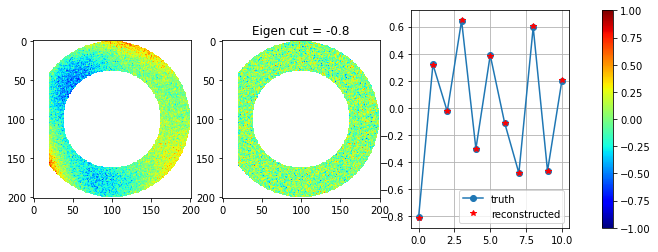

In [6]:
#create wavefront
cut = -0.8
x, y = np.meshgrid(x1d, x1d)
r = np.sqrt(x**2 + y**2)
idx = (r>1) | (r<e) | ((x< cut))

x[idx] = np.nan
y[idx] = np.nan
r[idx] = np.nan

w = ZernikeAnnularEval(zc, x, y, e)
w = w + np.random.normal(scale=1., size=w.shape) # noise
mask =  ~np.isnan(w) # good data
_mask =  np.isnan(w) # bad data

# setup an inverse variance or weight image
invar = 5.+ np.random.normal(scale=1., size=w.shape)
invar[_mask]=0.
    
zimages = eZ.createZernikeList(nzr, x, y, e)

# fit with the weighted zernike Images
evaluesWeight = eZ.zernikeWeightProjection(w, zimages[0:nzr], invar)
corr = eZ.correlationWeightMatrix(zimages, invar)
fitCoeffsWeight = eZ.zernikeProjectionMaskCorrection(evaluesWeight, corr)
wEigenFit = eZ.reconstructWavefront(fitCoeffsWeight, zimages[0:nzr])
plotZernikeFits(w, wEigenFit, zc, fitCoeffsWeight, cut=cut, title='Eigen')

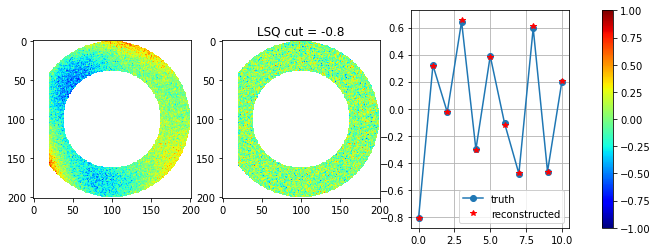

In [7]:
# refit with normal zernike fitting code 
zr = ZernikeMaskedFit(w, x, y, nzr, mask, e)
wLSFit = eZ.reconstructWavefront(zr, zimages)
plotZernikeFits(w, wLSFit, zc, zr, cut=cut, title='LSQ')

18174


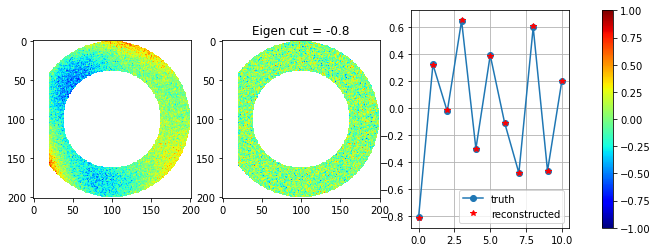

In [12]:
# refit with the mask (without variance weighting)
evalues = eZ.zernikeProjection(w, zimages[0:nzr], mask)
corr = eZ.correlationMatrix(zimages[0:nzr], mask)
fitCoeffsMask = eZ.zernikeProjectionMaskCorrection(evalues, corr)
wEigenFit = eZ.reconstructWavefront(fitCoeffsMask, zimages[0:nzr])
plotZernikeFits(w, wEigenFit, zc, fitCoeffsMask, cut=cut, title='Eigen')

Text(0, 0.5, 'Zernike coefficients with weight correction')

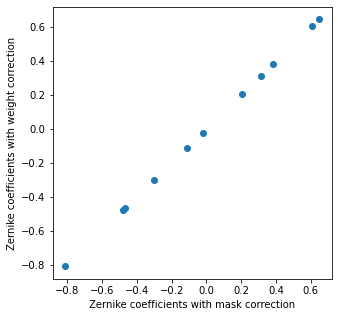

In [13]:
#Compare mask and weighted zernikes
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(fitCoeffsMask, fitCoeffsWeight)
ax.set_xlabel("Zernike coefficients with mask correction")
ax.set_ylabel("Zernike coefficients with weight correction")
